<a href="https://colab.research.google.com/github/hahachang/colab/blob/main/JobsBioParse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境設定

In [ ]:
#環境設定
!pip install selenium==4.0.0.b3
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

#wget https://chromedriver.storage.googleapis.com/96.0.4664.45/chromedriver_linux64.zip
#!unzip /content/colab/chromedriver_linux64.zip
#!cp /content/colab/chromedriver /usr/lib
#!cp /content/colab/chromedriver /usr/bin

#sys.path.insert(0,'/usr/bin/chromedriver')
!sudo apt install tesseract-ocr
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.26.9-py2.py3-none-any.whl (138 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-l

# 共通程式

In [ ]:
# Line Notify
def Line(msg,path_pic=None):
    import requests
    global tokenDropbox
    tokenLine = 'apfSt2nGRwzBuCuFWtH9qRCX8BGATHEyCiBAIQzAwup'

    headers = {
        "Authorization": "Bearer " + tokenLine
    }
    payload = {'message': msg}
    if path_pic!=None:
      files = {'imageFile':open(path_pic,'rb')}
      r = requests.post("https://notify-api.line.me/api/notify", headers = headers, params = payload,files=files)
    else:
      r = requests.post("https://notify-api.line.me/api/notify", headers = headers, params = payload)
    return r.status_code

def SendFileToDropbox(fileLocal,fileDropbox):
    ##### upload file to dropbox #####

    try:
        import dropbox
        #print("module is installed")
    except ModuleNotFoundError:
        print("module is not installed")
        # or
        !pip install dropbox
        import dropbox

    from dropbox.files import WriteMode
    from dropbox.exceptions import ApiError, AuthError
    global tokenDropbox
    tokenDropbox = "9VjbJCirSqsAAAAAAAA1JuBzv7mujcQGbebgTGu2IjDup-N77QjVY8MEsg1ccizx"
    dbx = dropbox.Dropbox(tokenDropbox)
    with open(fileLocal, 'rb') as f:
      dbx.files_upload(f.read(), "/"+fileDropbox, mode=WriteMode('overwrite')) 
      f.close()


def GetFileFromDropbox(fileDropbox,fileLocal):
    ##### download file frome dropbox #####
    try:
        import dropbox
        #print("module is installed")
    except ModuleNotFoundError:
        print("module is not installed")
        # or
        !pip install dropbox
        import dropbox

    from dropbox.files import WriteMode
    from dropbox.exceptions import ApiError, AuthError
    global tokenDropbox
    tokenDropbox = "9VjbJCirSqsAAAAAAAA1JuBzv7mujcQGbebgTGu2IjDup-N77QjVY8MEsg1ccizx"
    dbx = dropbox.Dropbox(tokenDropbox)
    with open(fileLocal, "wb") as f:
      metadata, res = dbx.files_download("/"+fileDropbox)
      f.write(res.content)

In [ ]:
#設定
import sys
import os
import base64 
import datetime
import time
import json
import pandas as pd

from datetime import datetime,timedelta
from pathlib import Path 
from urllib.parse import urlparse
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException

#global
#global tokenDropbox,tokenLine
#tokenDropbox = "9VjbJCirSqsAAAAAAAA1JuBzv7mujcQGbebgTGu2IjDup-N77QjVY8MEsg1ccizx"
#tokenLine = 'apfSt2nGRwzBuCuFWtH9qRCX8BGATHEyCiBAIQzAwup'

#設定Selenium
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

prjName = "OCR_Img_twse_bsr"

headLess = True

Path(prjName).mkdir(parents=True, exist_ok=True)

# 如要使用Chrome瀏覽器，需使用相對應版本的ChromeDriver
# Src: https://chromedriver.chromium.org/
wdPath = '/usr/lib/chromium-browser/chromedriver'
#wdPath = '/usr/lib/chromedriver'

# 函數:Stock

In [ ]:
def StartdayParseStock():
  from datetime import datetime, timedelta
  if (datetime.now()+timedelta(hours=8)).strftime("%H%M%S")<"160000":
    date   = (datetime.now()+timedelta(hours=8)+timedelta(days=-1)).strftime("%Y%m%d")  
  else:
    date   = (datetime.now()+timedelta(hours=8)).strftime("%Y%m%d")
  return date

global dateStartday
dateStartday =  StartdayParseStock()
print("======  " +  dateStartday  + "  ======"  )
#dateStartday="20210514"

======  20220629  ======


# 主程式:StockBio

In [ ]:
def ParseBioCSV(stock):
  print('chromedriver is lunching..')
  wd = webdriver.Chrome(options=options)
  #time.sleep(1)
  print('chromedriver is ready..')

  #抓取captcha
  urlString = "https://bsr.twse.com.tw/bshtm/bsMenu.aspx"
  parsed_uri = urlparse(urlString)
  # from urlparse import urlparse  # Python 2
  #result = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
  sitePath = '{uri.hostname}'.format(uri=parsed_uri)

  imgPath = prjName + "\\" + sitePath
  Path(imgPath).mkdir(parents=True, exist_ok=True)

  print('get web page....Start')
  wd.get(urlString)
  #time.sleep(1)
  print('get web page....Done')

  def get_captcha_img(): # return saved file's name
      # 此網站的動態驗證碼是存放在 tag img
      #target_img = wd.find_element_by_id("authPic")
      target_img = wd.find_element_by_css_selector("#Panel_bshtm img")
      
      # get the canvas as a PNG base64 string
      img_base64 = wd.execute_script("x=arguments[0];c=document.createElement('canvas');c.width=x.width,c.height=x.height;t=c.getContext('2d');t.drawImage(x, 0, 0);return c.toDataURL('image/png').substring(21);", target_img)
      
      # decode
      img_png = base64.b64decode(img_base64)
      
      # save to a file
      dtNow = datetime.now()
      
      fileName = '{}\\{}{}{}_{}{}{}.png'
      fileName = fileName.format(imgPath, dtNow.strftime("%Y"), dtNow.strftime("%m"), dtNow.strftime("%d"), dtNow.strftime("%H"), dtNow.strftime("%M"), dtNow.strftime("%S"))
      with open(fileName, 'wb') as f:
          f.write(img_png)
      return fileName

  fileName=get_captcha_img()

  print('png saved')

  #OCR
  # 載入圖形相關函式

  try:
      from PIL import Image
  except ImportError:
      import Image
  import PIL.ImageOps 
  import pytesseract

  from IPython.display import display

  def convert_img1(img, threshold): # 先灰階，轉補色，再黑白處理
      img = img.convert("L")  # 轉為灰階
      img = PIL.ImageOps.invert(img)
      pixels = img.load()
      for x in range(img.width):
          for y in range(img.height):
              if pixels[x, y] > threshold:
                  pixels[x, y] = 255
              else:
                  pixels[x, y] = 0
      return img

  # 8鄰域降燥辨識
  def noise_remove_pil(img, ctrlG, ctrlK): # 8鄰域降噪, ctrlG:小餘折是非白, ctrlK:小於ctrlK個非白點就轉白
      def calculate_noise_count(img_obj, w, h): # 計算鄰域非白色的個數
          count = 0
          width, height = img_obj.size
          for _w_ in [w - 1, w, w + 1]:
              for _h_ in [h - 1, h, h + 1]:
                  if _w_ > width - 1:
                      continue
                  if _h_ > height - 1:
                      continue
                  if _w_ == w and _h_ == h:
                      continue
                  if img_obj.getpixel((_w_, _h_)) < ctrlG:  # 這裡因為是灰度影像，設定小於230為非白色
                      count += 1
          return count

      img = img.convert("L")
      img = PIL.ImageOps.invert(img)
      w, h = img.size
      
      for _w in range(w):
          for _h in range(h):
              if _w == 0 or _h == 0:
                  img.putpixel((_w, _h), 255)
                  continue
              pixel = img.getpixel((_w, _h))
              if pixel == 255:
                  continue

              # 計算鄰域非白色的個數
              if calculate_noise_count(img, _w, _h) < ctrlK:
                  img.putpixel((_w, _h), 255)
      return img

  captcha4 = Image.open(fileName)
  captcha4 = noise_remove_pil(captcha4, 10, 4)

  result4 = pytesseract.image_to_string(captcha4)
  print(result4)
  #display(captcha4)

  # 二值化降噪辨識，又稱8鄰域降燥，灰階圖辨識與轉黑白後辨識有的時候會不同效益
  def depointImg(img, ctrlV, ctrlK): # 二值化降噪辨識，大於ctrlV是為白點，超過ctrlK個白點轉白
      img = img.convert("L")
      img = PIL.ImageOps.invert(img)
      pixels = img.load()
      w, h = img.size
      for y in range(1, h - 1):
          for x in range(1, w - 1):
              count = 0
              if pixels[x - 1, y - 1] > ctrlV:  # 左上
                  count = count + 1
              if pixels[x,     y - 1] > ctrlV:  # 上
                  count = count + 1
              if pixels[x + 1, y - 1] > ctrlV:  # 右上
                  count = count + 1
                  
              if pixels[x - 1, y] > ctrlV:  # 左
                  count = count + 1
              if pixels[x + 1, y] > ctrlV:  # 右
                  count = count + 1

              if pixels[x - 1, y + 1] > ctrlV:  # 左下
                  count = count + 1
              if pixels[x,     y + 1] > ctrlV:  # 下
                  count = count + 1
              if pixels[x + 1, y + 1] > ctrlV:  # 右下
                  count = count + 1
                  
              if count > ctrlK:
                  pixels[x, y] = 255
      return img


  captcha5 = Image.open(fileName)
  captcha5 = depointImg(captcha5, 10, 4)

  result5 = pytesseract.image_to_string(captcha5)
  print(result5)
  #display(captcha5)

  result4 = result4.replace(' ', '').strip()
  result5 = result5.replace(' ', '').strip()
  print('r4=' + result4)
  print('r5=' + result5)
  display(captcha4)
  display(captcha5)
  captchaCode=''

  if len(result5)==5:
      captchaCode=result5
      print('captcha5 identified!!')
  elif len(result4)==5:
      captchaCode=result4
      print('captcha4 identified!!')
  else:
      print('captcha identify failled!')
      parseSuccess = "No"

  if len(captchaCode)==5:
      txtStkCode = wd.find_element_by_id("TextBox_Stkno")
      txtStkCode.send_keys(stock)
    
      txtCaptcha = wd.find_element_by_name("CaptchaControl1")
      txtCaptcha.send_keys(captchaCode)
      btnOK = wd.find_element_by_id("btnOK")
      btnOK.click()
      try:
          dd = wd.find_element_by_id("HyperLink_DownloadCSV") 
          dd.click()
          print('file downloading...')
          sleep(5)
          while not os.path.exists(stock + ".csv"):
            sleep(2)
            print("file downloading..wait")    
          parseSuccess = "Yes"
      except NoSuchElementException:
          print('captcha code error!')
          parseSuccess = "No"

  print('chromedriver closing..')
  wd.quit()
  print('chromedriver closed..')
  
  return parseSuccess  


In [ ]:
def GetProgressFromDropbox(machine):
  import pandas as pd
  fileProgress = "bio\\"+str(dateStartday)+"\\"+"bio_progress"+str(machine)+".csv" 
  GetFileFromDropbox("bio/"+str(dateStartday)+"/"+"bio_progress"+str(machine)+".csv","\\"+fileProgress )
  loopsDropbox = pd.read_csv("\\"+fileProgress, names=["col"],header=None, dtype = str).col.tolist()
  return loopsDropbox

def SendProgressToDropbox(nowProgress,machine):
  import pandas as pd
  fileProgress = "bio\\"+str(dateStartday)+"\\"+"bio_progress" + str(machine) + ".csv" 
  pd.DataFrame(nowProgress).to_csv("\\"+fileProgress,index= False,header=False)
  SendFileToDropbox("\\"+fileProgress,"bio/"+str(dateStartday)+"/"+"bio_progress"+str(machine)+".csv")
  print("Send Progress"+ str(machine)+ " to Dropbox ..")

In [ ]:
#print("====  "+ "Remain:" +str(len(GetProgressFromDropbox())) + "jobs" + "  =====")

In [ ]:
def DynamicLoopsParseBioCSV(machine):
    from pathlib import Path 

    bioPath = "bio" + "\\" + str(dateStartday)
    Path(bioPath).mkdir(parents=True, exist_ok=True)

    try:
      loopsDropbox = GetProgressFromDropbox(machine)
      print("get bio progress from dropbox ..")
    except:
      print('error:get bio progress from dropbox ..')
      loopsDropbox = []

    if len(loopsDropbox)==0:
      print("new progress ..")
      if "jf" not in locals() and "jf" not in globals():
        jf  = ParseTWSE_OHLC(dateStartday)
      loops = LoopsTWSE_OHLC(jf)
    else:
      print("continue progress ..")
      loops = loopsDropbox
    
    return loops,loopsDropbox

In [ ]:
def ExecuteLoopsBio(loops):
  Line( str(machine)+": start")
  for stock in loops:
    #line to notify
    #Line( str(machine)+":"+str(stock)+",Remain:"+str(len(loops)) )
    
    #use selenium to download file
    parseSuccess="No"
    while parseSuccess=="No":
      print("====  "+str(stock)+" parsing .. "+"  ====")
	    try:      
        parseSuccess = ParseBioCSV(stock)
        sleep(randint(5,7))
        clear_output(wait=True)
      except:
        sleep(randint(60,90))
      
    #rename file and send to dropbox 
    if parseSuccess == "Yes":
      #Rename file
      timestamp = (datetime.now()+timedelta(hours=8)).strftime("%Y%m%d_%H%M%S")
      boxfile   = str(stock)+"_"+timestamp+".csv"
      os.rename(str(stock)+".csv",boxfile)
      print('renameCSV closed..')

      #send bio to Dropbox
      SendFileToDropbox(boxfile, "bio/"+dateStartday +"/"+ boxfile)
      print('csv to dropbox closed..')

      #send progress to Dropbox
      loops = loops[1:len(loops)]
      SendProgressToDropbox(loops,machine)

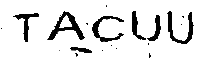

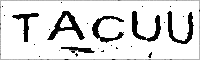

captcha5 identified!!


/usr/local/lib/python3.7/dist-packages/selenium/webdriver/remote/webdriver.py:412: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")
/usr/local/lib/python3.7/dist-packages/selenium/webdriver/remote/webdriver.py:572: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")


file downloading...
chromedriver closing..
chromedriver closed..
renameCSV closed..
csv to dropbox closed..


In [ ]:
from time import sleep
from random import randint
from IPython.display import clear_output

wd = webdriver.Chrome(options=options)
loops,loopsDropbox = DynamicLoopsParseBioCSV(machine)
ExecuteLoopsBio(loops)